In [ ]:
%config InlineBackend.figure_format = 'retina'

In [ ]:
#|hide
%pip install -Uqq pandas seaborn ds_tut

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd

import pickle

from pathlib import Path

import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline
import matplotlib.pyplot as plt

# Text Classification (Reuters-21578)

## Additional Information About the Dataset
- [Paper comparing different text categorization methods (Thorsten Joachims 1998)](https://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf)
- [Dataset Readme](http://www.daviddlewis.com/resources/testcollections/reuters21578/readme.txt)
- [Link to Dataset Card on Hugging Face](https://huggingface.co/datasets/reuters21578)

Maybe just use the dataset from Hugging Face instead of downloading and parsing manually? TODO

## Prepare Dataset

### Download

In [ ]:
#|notest
from ds_tut import download_from_url

archive_name = "reuters21578.tar.gz"
training_data_url = "http://www.daviddlewis.com/resources/testcollections/reuters21578/{}".format(archive_name)
data_root = Path.cwd() / "data" / "tmp"
data_root.mkdir(parents=True, exist_ok=True)
training_data_path = data_root / archive_name
reuters_dir = data_root / archive_name.split(".")[0]
data_size = download_from_url(training_data_url, training_data_path)

### Unpack

In [ ]:
#|notest
import tarfile

tar = tarfile.open(str(training_data_path))
tar.extractall(path=str(reuters_dir))
tar.close()

### Parse

In [ ]:
#|notest
import pickle

from ds_tut.datasets import ReutersParser, ReutersCorpus

documents = []
rp = ReutersParser()
for sgml_path in reuters_dir.glob("*.sgm"):
    for doc in rp.parse_sgml(str(sgml_path)):
        doc["filename"] = sgml_path
        documents.append(doc)

pickle_path = reuters_dir / "documents.pkl"
with open(str(pickle_path), "wb") as f:
    pickle.dump(documents, f)

reuters = ReutersCorpus(documents)

pickle_path = reuters_dir / "corpus.pkl"
with open(str(pickle_path), "wb") as f:
    pickle.dump(reuters, f)

## Explore Reuters-21578

### Load dataset

In [ ]:
#|notest
from ds_tut.datasets import ReutersCorpus

data_root = Path.cwd() / "data" / "tmp"
reuters_documents_path = data_root / "reuters21578" / "documents.pkl"
reuters_corpus_path = data_root / "reuters21578" / "corpus.pkl"

documents = pickle.load(open(reuters_documents_path, "rb"))
reuters = pickle.load(open(reuters_corpus_path, "rb"))
df, top_ten_ids, train_labels, test_labels = reuters.build_dataframe(pd=pd)
train, test = reuters.split_modapte()

## Get some simple stats

In [ ]:
#|notest
number_of_samples = reuters.number_of_samples
number_of_classes = reuters.number_of_classes
number_of_samples_per_class = int(np.average([tc for tc in reuters.topic_counts.values() if tc > 1]))
number_of_words_per_sample = int(np.median([len(d["text"].split()) for d in reuters.docs]))
samples_to_words_per_sample_ratio = int(number_of_samples / number_of_words_per_sample)

In [ ]:
#|notest
nchars = 52
print("Number of samples:".ljust(nchars), reuters.number_of_samples)
print("Number of classes:".ljust(nchars), reuters.number_of_classes)
print("Number of samples per class:".ljust(nchars), number_of_samples_per_class)
print("Number of words per sample:".ljust(nchars), number_of_words_per_sample)
print("Number of samples/number of words per sample ratio:".ljust(nchars), samples_to_words_per_sample_ratio)

Number of samples:                                   10789
Number of classes:                                   119
Number of samples per class:                         148
Number of words per sample:                          89
Number of samples/number of words per sample ratio:  121


## Distribution of sample length for reuters21578

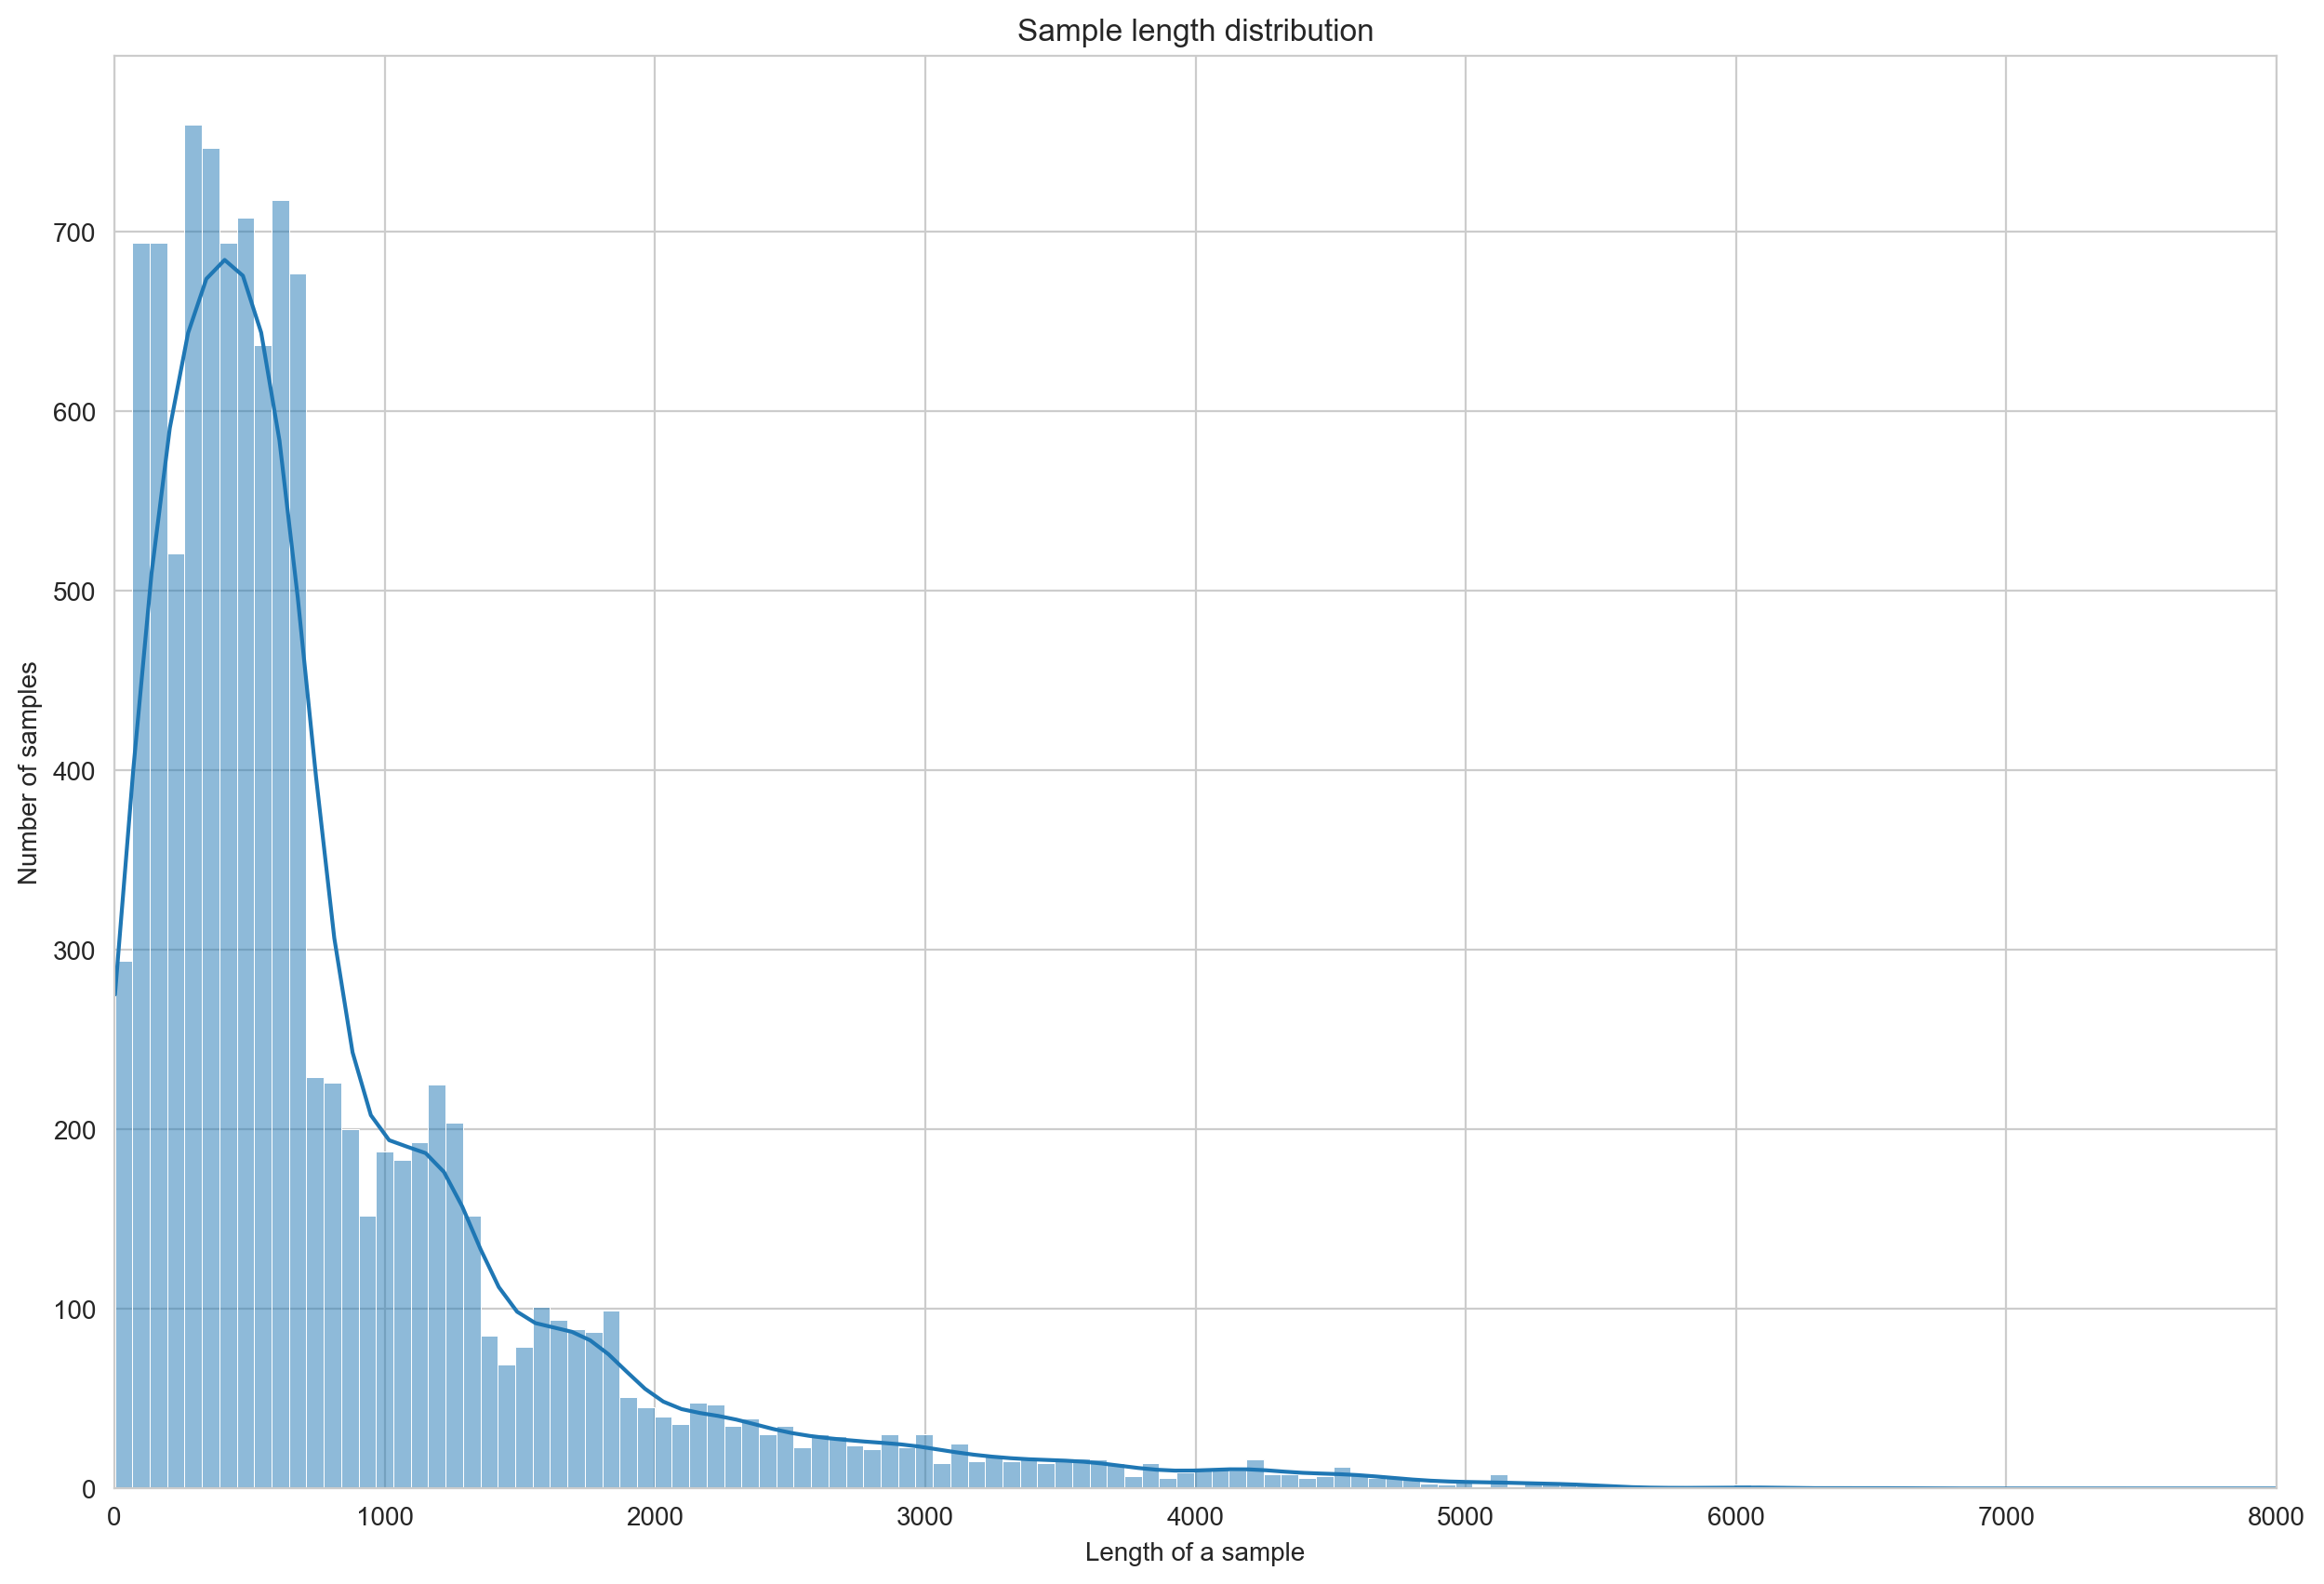

In [ ]:
#|notest
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot([len(d["text"]) for d in reuters.docs], kde=True, ax=ax)
ax.set_title('Sample length distribution')
ax.set_xlabel('Length of a sample')
ax.set_xlim(0, 8000)
_ = ax.set_ylabel('Number of samples')

## Word frequency distribution

In [ ]:
%pip install -Uqq scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#|notest
from sklearn.feature_extraction.text import CountVectorizer

kwargs = {
        'ngram_range': (1, 1),
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': 'word',  # Split text into word tokens.
}
vectorizer = CountVectorizer(**kwargs)
vectorized_texts = vectorizer.fit_transform(reuters.texts)
all_ngrams = list(vectorizer.get_feature_names_out())
all_counts = vectorized_texts.sum(axis=0).tolist()[0]
all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
    zip(all_counts, all_ngrams), reverse=True)])

num_ngrams=50
ngrams = list(all_ngrams)[:num_ngrams]
counts = list(all_counts)[:num_ngrams]
idx = np.arange(num_ngrams)

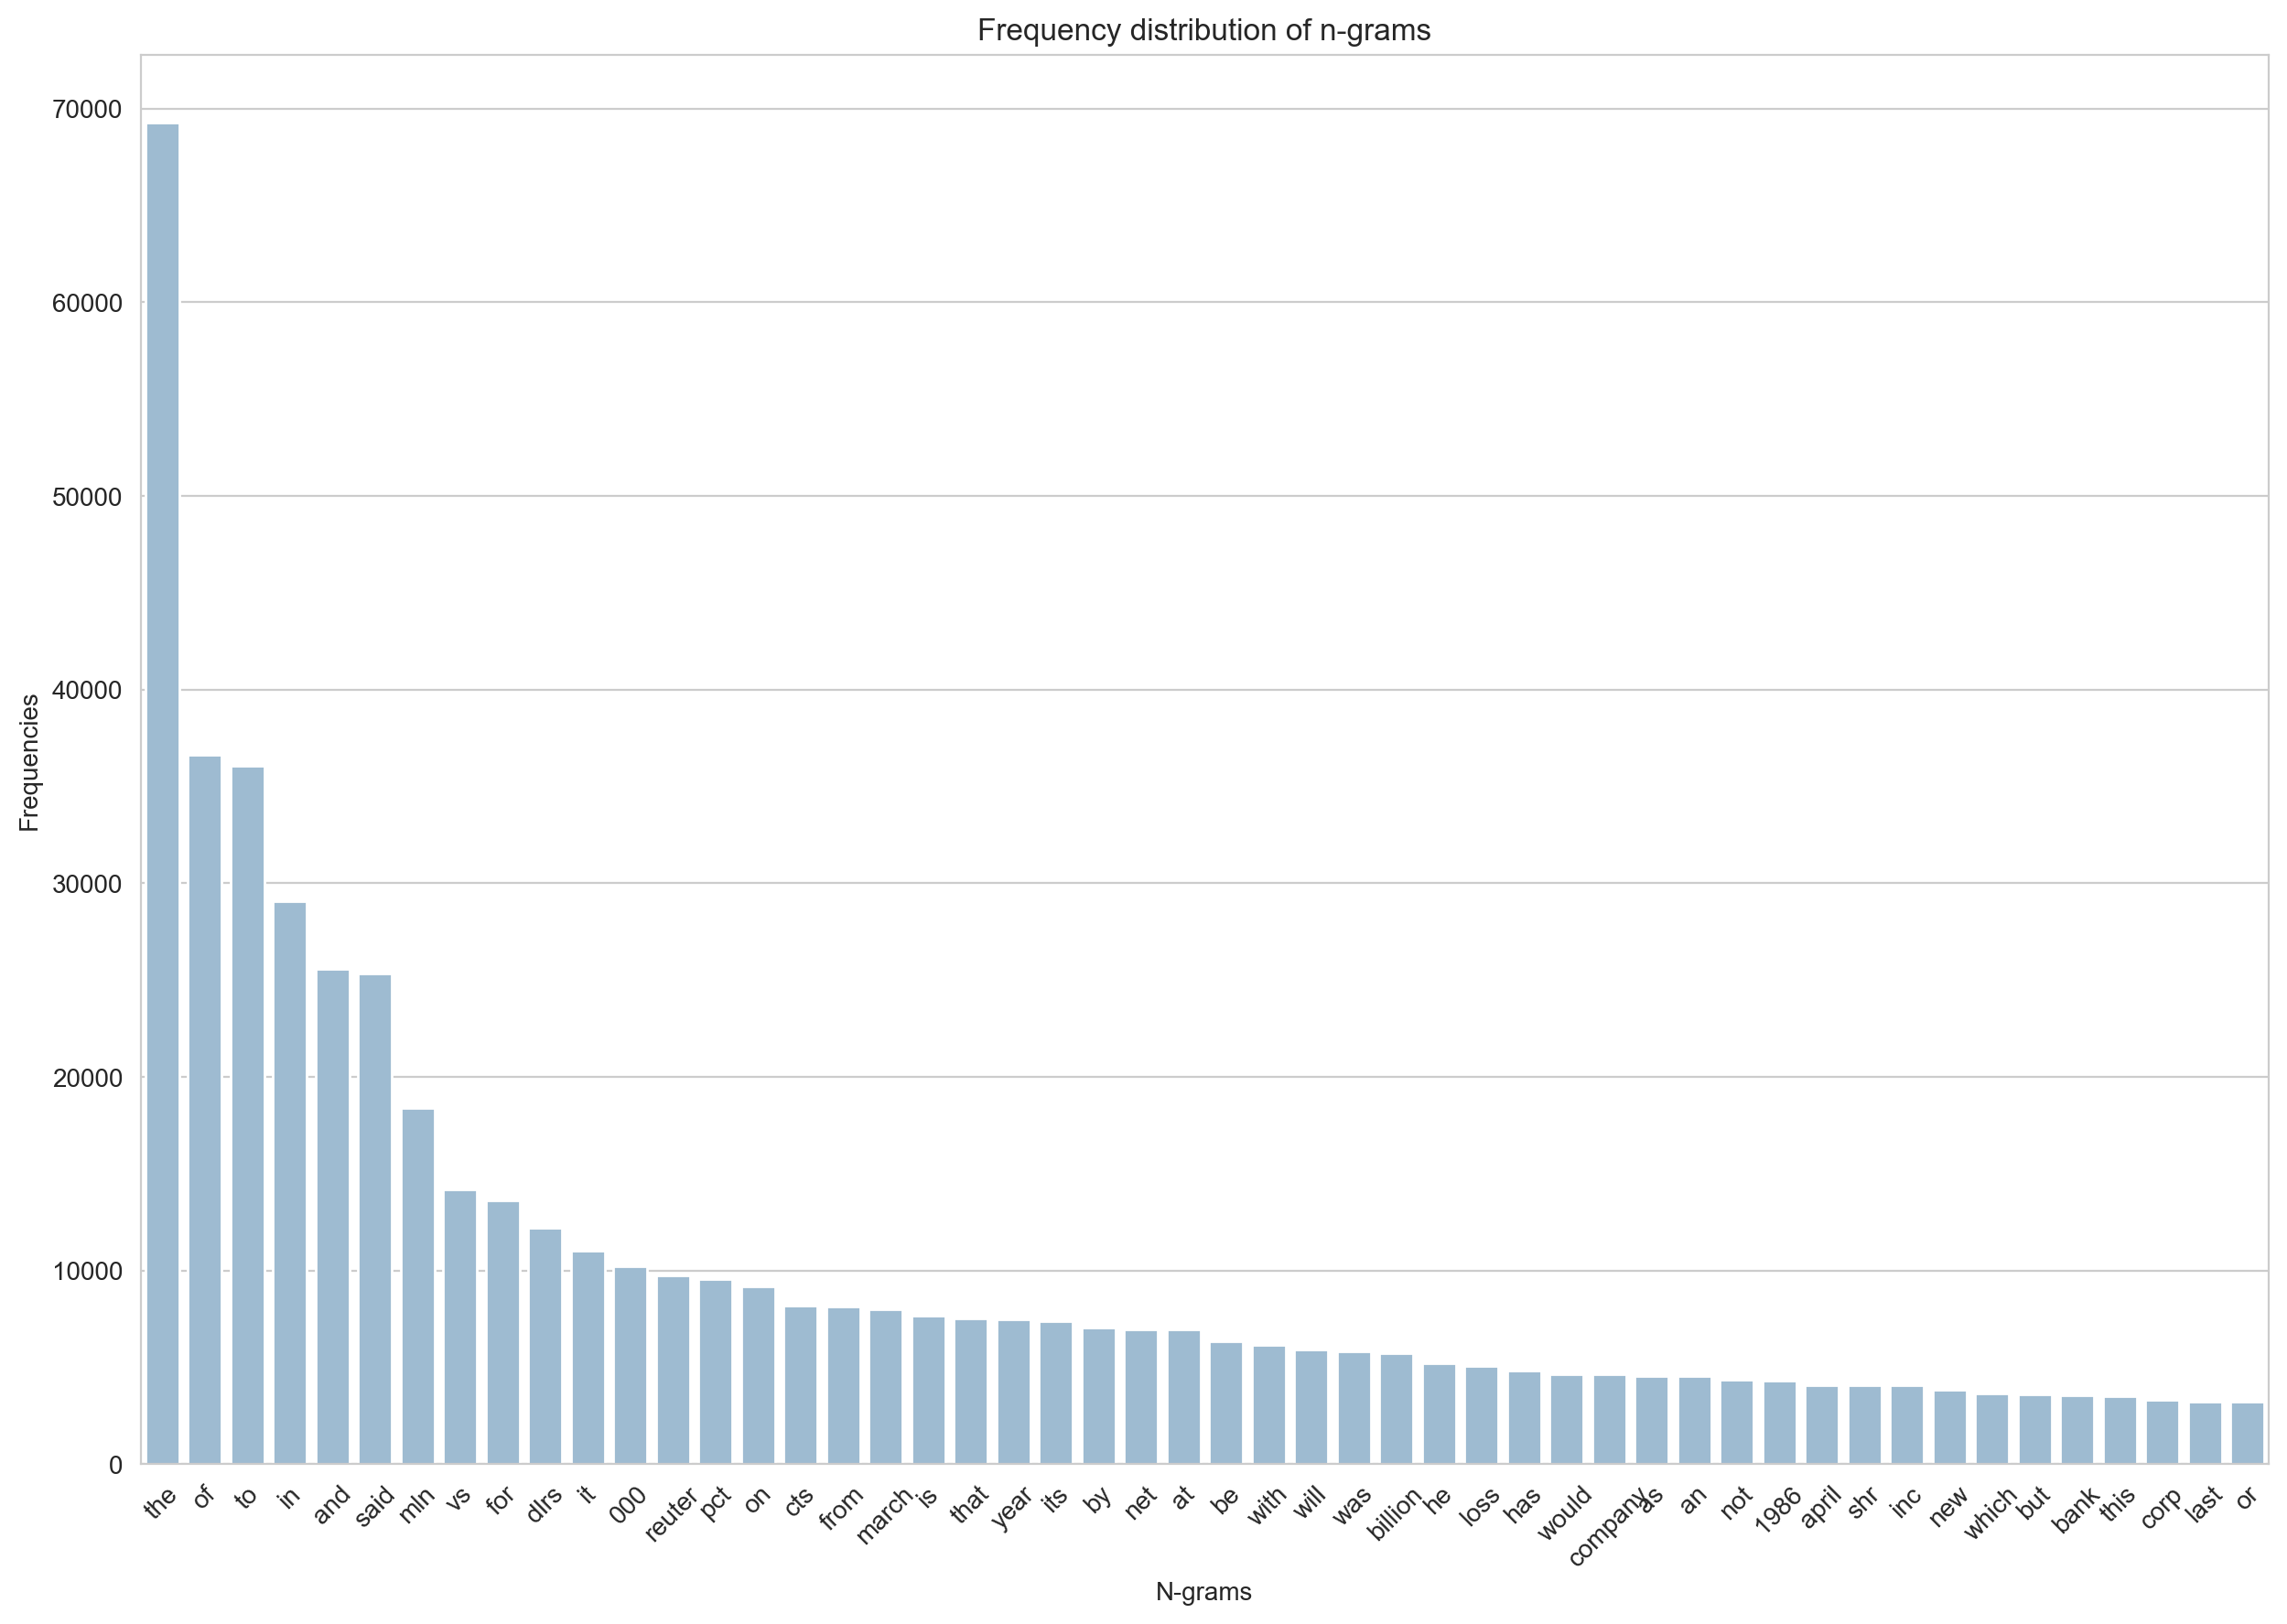

In [ ]:
#|notest
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=ngrams, y=counts, ax=ax, color="#95BCD9")
ax.set_title('Sample length distribution')
plt.xlabel('N-grams')
_ = plt.ylabel('Frequencies')
_ = plt.title('Frequency distribution of n-grams')
_ = plt.xticks(idx, ngrams, rotation=45)

## Choose a model flowchart

In [ ]:
#|notest
from IPython.display import Image
from IPython.core.display import HTML
print("Number of samples/number of words per sample ratio: ", samples_to_words_per_sample_ratio)
Image(url=(
    "https://developers.google.com/machine-learning/guides/"
    "text-classification/images/TextClassificationFlowchart.png"
))

Number of samples/number of words per sample ratio:  121
